In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

! pip3 install grpcio==1.34


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
%%bash

cd models/research/

protoc object_detection/protos/*.proto --python_out=.

cp object_detection/packages/tf2/setup.py .
pip3 install .

python3 object_detection/builders/model_builder_test.py

Defaulting to user installation because normal site-packages is not writeable
Processing /home/pehovorka/Dokumenty/street-object-detection/jupyter/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1655595 sha256=aad326697d3fa454fb980afefcfcba827bfc7bfe5c584b73b8daa3ee9c3e862e
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt69nzzf/wheels/71/54/f4/cac2879c6027b419023b1cbc083102bd9091f71dd67b40e9bd
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
2021-06-20 10:05:42.725002: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import io
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

%cd models/research
from object_detection.utils import visualization_utils as viz_utils



%matplotlib inline

/home/pehovorka/Dokumenty/street-object-detection/jupyter/models/research


In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be locif not os.path.exists('tensorflow_object_counting_api'):
  ! git clone https://github.com/ahmetozlu/tensorflow_object_counting_apigal or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [5]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget -N http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz

test_data_dir = os.path.join('object_detection','test_data')
if not os.path.exists(test_data_dir):
    !mv efficientdet_d5_coco17_tpu-32/ test_data_dir
    
# Load pretrained model
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load(os.path.join(test_data_dir,'efficientdet_d5_coco17_tpu-32','saved_model'))
end_time = time.time()
elapsed_time = end_time - start_time
print('Model loading time: ' + str(elapsed_time) + 's')

--2021-06-20 10:05:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
Překládám download.tensorflow.org (download.tensorflow.org)… 172.217.23.208, 2a00:1450:4014:80c::2010
Navazuje se spojení s download.tensorflow.org (download.tensorflow.org)|172.217.23.208|:80… spojeno.
HTTP požadavek odeslán, program čeká na odpověď… 304 Not Modified
Soubor „efficientdet_d5_coco17_tpu-32.tar.gz“ nebyl na serveru změněn. Stažení se vynechává.



Model loading time: 47.49270296096802s


In [6]:
dataset_dir = os.path.join('..','..','..','dataset','theatre_dataset_images')
list_of_all_images = os.listdir(dataset_dir)
output_dir = os.path.join('..','..','..','tf_output')

# Create the output dir if does not already exist.
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# The day (start of the filename) to analyze
day = '2021-06-04'

# Filter only the files whose filenames start with the chosen day
list_of_selected_images = [filename for filename in list_of_all_images if filename.startswith(day)]


# Create empty dict of hours with nested dict of watched classes.
# It will be later used for counting instances of such classes in particular hours.
hour_bins = {
    el: {
        'people': 0, 
        'cars': 0, 
        'bicycles': 0, 
        'dogs': 0
    } 
    for el in range(24)
}


# Print available GPUs
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
elapsed = []
for i in range(len(list_of_selected_images)):
  image_path = os.path.join(dataset_dir, list_of_selected_images[i])
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  #all_detections[list_of_selected_images[i]] = detections
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()


  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),        
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  #plt.subplot(128, 1, i+1)

  fig = plt.figure(frameon=False)
  fig.set_size_inches(12,9)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(image_np_with_detections, aspect='auto')
  output_path = os.path.join(output_dir, list_of_selected_images[i])
  fig.savefig(output_path)
  plt.close(fig) 

  objects = []
  for index,value in enumerate(detections['detection_classes'][0].numpy()):
    if detections['detection_scores'][0,index].numpy() > .40:
        objects.append(category_index.get(value))
    
  people = len(list(filter(lambda x: x['name'] == 'person', objects)))
  bicycles = len(list(filter(lambda x: x['name'] == 'bicycle', objects))) 
  cars = len(list(filter(lambda x: x['name'] == 'car', objects)))
  dogs = len(list(filter(lambda x: x['name'] == 'dog', objects)))
    
  print(list_of_selected_images[i] + ': people: ' + str(people) + ' | cars: ' + str(cars) \
        + ' | bicycles: ' + str(bicycles) + ' | dogs: ' + str(dogs))

  substr_hour = list_of_selected_images[i][11:13]
  hour_bins[int(substr_hour)] = {
        'people': hour_bins[int(substr_hour)]['people'] + people, 
        'cars': hour_bins[int(substr_hour)]['cars'] + cars, 
        'bicycles': hour_bins[int(substr_hour)]['bicycles'] + bicycles, 
        'dogs': hour_bins[int(substr_hour)]['dogs'] + dogs
  }
  
  # plt.imshow(image_np_with_detections)

average_elapsed = sum(elapsed) / float(len(elapsed))
print('Total time: ' + str(sum(elapsed)) + ' seconds')
print('Average time: ' + str(average_elapsed) + ' second per image')

2021-06-04 21:19:00.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 03:48:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 04:37:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 14:16:01.jpg: people: 6 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 01:02:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 06:22:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 08:08:00.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 18:20:01.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 20:53:01.jpg: people: 12 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 03:33:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 07:30:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 00:13:00.jpg: people: 2 | cars: 0 | bicycles: 1 | dogs: 0
2021-06-04 18:12:00.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 14:08:00.jpg: people: 4 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 01:48:00.jpg: people: 

2021-06-04 03:41:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 04:24:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 01:57:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 07:39:00.jpg: people: 1 | cars: 8 | bicycles: 1 | dogs: 0
2021-06-04 04:14:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 17:20:01.jpg: people: 8 | cars: 5 | bicycles: 1 | dogs: 0
2021-06-04 11:16:01.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 07:36:00.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 20:45:00.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 03:38:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 13:55:01.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 04:29:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 05:03:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 10:36:01.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 1
2021-06-04 00:16:01.jpg: people: 0

2021-06-04 11:06:00.jpg: people: 2 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 07:35:02.jpg: people: 0 | cars: 6 | bicycles: 0 | dogs: 0
2021-06-04 12:10:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 23:47:00.jpg: people: 0 | cars: 7 | bicycles: 0 | dogs: 0
2021-06-04 02:18:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 16:43:00.jpg: people: 7 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 17:28:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 13:12:01.jpg: people: 4 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 06:23:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 18:46:01.jpg: people: 14 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 18:36:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 17:46:00.jpg: people: 4 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 01:33:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 18:31:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 07:46:00.jpg: people: 

2021-06-04 06:27:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 01:07:00.jpg: people: 3 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 08:00:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 19:53:00.jpg: people: 10 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 05:00:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 13:53:01.jpg: people: 12 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 04:33:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 09:46:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 13:05:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 11:04:00.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 21:26:00.jpg: people: 11 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 08:24:01.jpg: people: 1 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 09:47:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 19:45:01.jpg: people: 3 | cars: 6 | bicycles: 1 | dogs: 0
2021-06-04 16:09:00.jpg: people

2021-06-04 10:57:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 13:56:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 02:43:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 02:11:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 00:56:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 11:02:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 04:11:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 01:15:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 17:31:00.jpg: people: 3 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 12:32:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 15:53:01.jpg: people: 3 | cars: 6 | bicycles: 0 | dogs: 0
2021-06-04 02:49:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 23:57:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 05:55:01.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 07:27:00.jpg: people: 1

2021-06-04 22:07:01.jpg: people: 6 | cars: 8 | bicycles: 0 | dogs: 0
2021-06-04 11:11:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 16:31:00.jpg: people: 3 | cars: 3 | bicycles: 1 | dogs: 0
2021-06-04 09:30:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 11:07:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 03:55:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 12:47:01.jpg: people: 0 | cars: 6 | bicycles: 0 | dogs: 0
2021-06-04 15:45:00.jpg: people: 11 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 03:24:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 21:47:01.jpg: people: 6 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 20:12:00.jpg: people: 4 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 06:51:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 08:56:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 07:23:00.jpg: people: 0 | cars: 6 | bicycles: 0 | dogs: 0
2021-06-04 19:55:00.jpg: people: 

2021-06-04 10:03:00.jpg: people: 0 | cars: 12 | bicycles: 0 | dogs: 0
2021-06-04 17:59:01.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 16:54:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 18:10:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 19:52:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 23:42:01.jpg: people: 0 | cars: 8 | bicycles: 0 | dogs: 0
2021-06-04 20:40:00.jpg: people: 11 | cars: 3 | bicycles: 1 | dogs: 0
2021-06-04 14:13:01.jpg: people: 6 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 11:53:00.jpg: people: 4 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 23:31:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 00:41:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 10:13:01.jpg: people: 1 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 10:39:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 02:31:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 12:22:00.jpg: people:

2021-06-04 11:32:00.jpg: people: 5 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 13:26:00.jpg: people: 7 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 20:04:00.jpg: people: 8 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 02:34:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 13:14:00.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 07:09:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 23:41:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 08:28:01.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 04:49:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 07:33:01.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 00:34:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 17:29:00.jpg: people: 5 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 10:12:01.jpg: people: 4 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 03:15:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 01:31:00.jpg: people: 2

2021-06-04 22:21:00.jpg: people: 9 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 13:15:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 09:43:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 14:22:00.jpg: people: 4 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 18:51:00.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 05:34:01.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 09:20:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 07:57:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 20:41:00.jpg: people: 9 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 01:32:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 15:07:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 06:05:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 08:09:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 02:24:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 03:39:00.jpg: people: 3

2021-06-04 23:11:00.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 06:10:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 19:47:01.jpg: people: 11 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 03:26:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 22:41:00.jpg: people: 9 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 00:44:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 13:34:00.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 00:54:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 11:00:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 03:51:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 06:52:01.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 18:06:00.jpg: people: 6 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 16:39:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 05:30:01.jpg: people: 1 | cars: 0 | bicycles: 1 | dogs: 0
2021-06-04 08:31:01.jpg: people: 

2021-06-04 16:42:01.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 09:10:01.jpg: people: 2 | cars: 5 | bicycles: 1 | dogs: 0
2021-06-04 18:57:00.jpg: people: 2 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 11:12:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 00:07:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 10:19:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 08:21:00.jpg: people: 2 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 14:50:00.jpg: people: 3 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 12:35:00.jpg: people: 0 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 09:49:01.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 08:52:01.jpg: people: 1 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 00:24:00.jpg: people: 0 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 09:54:01.jpg: people: 3 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 22:10:00.jpg: people: 7 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 13:44:00.jpg: people: 1

2021-06-04 13:28:01.jpg: people: 10 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 05:16:00.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 23:20:01.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 17:04:00.jpg: people: 4 | cars: 1 | bicycles: 3 | dogs: 0
2021-06-04 23:19:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 07:37:00.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 13:36:00.jpg: people: 5 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 06:42:00.jpg: people: 2 | cars: 0 | bicycles: 1 | dogs: 0
2021-06-04 03:00:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 10:16:01.jpg: people: 0 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 22:48:01.jpg: people: 3 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 16:13:00.jpg: people: 3 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 05:06:00.jpg: people: 1 | cars: 0 | bicycles: 0 | dogs: 0
2021-06-04 08:49:00.jpg: people: 2 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 13:03:00.jpg: people: 

2021-06-04 01:59:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 15:46:00.jpg: people: 6 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 18:39:00.jpg: people: 2 | cars: 6 | bicycles: 0 | dogs: 0
2021-06-04 04:48:01.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
2021-06-04 04:26:00.jpg: people: 0 | cars: 4 | bicycles: 0 | dogs: 0
2021-06-04 09:14:01.jpg: people: 5 | cars: 5 | bicycles: 2 | dogs: 0
2021-06-04 14:19:00.jpg: people: 3 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 13:06:01.jpg: people: 1 | cars: 5 | bicycles: 0 | dogs: 0
2021-06-04 23:27:00.jpg: people: 4 | cars: 2 | bicycles: 0 | dogs: 0
2021-06-04 14:33:01.jpg: people: 2 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 10:42:00.jpg: people: 1 | cars: 3 | bicycles: 0 | dogs: 0
2021-06-04 10:00:00.jpg: people: 0 | cars: 1 | bicycles: 0 | dogs: 0
Total time: 1379.4038112163544 seconds
Average time: 0.9579193133446905 second per image


    people  cars  bicycles  dogs
0       44    80         1     0
1       15    65         0     0
2        5    36         0     0
3        6    20         0     0
4        4    36         1     0
5       18    26         2     0
6       21    52         3     0
7       50   134         7     1
8       59   209         8     0
9       88   191        10     0
10      79   191         5     1
11     127   182         2     0
12     121   174         0     0
13     205   206         3     0
14     216   150        10     0
15     231   236         8     1
16     243   230        17     0
17     302   159        18     0
18     330   165         6     0
19     349   156        11     1
20     357   173         6     1
21     292   144         2     0
22     316   180         3     0
23     151   136         1     0


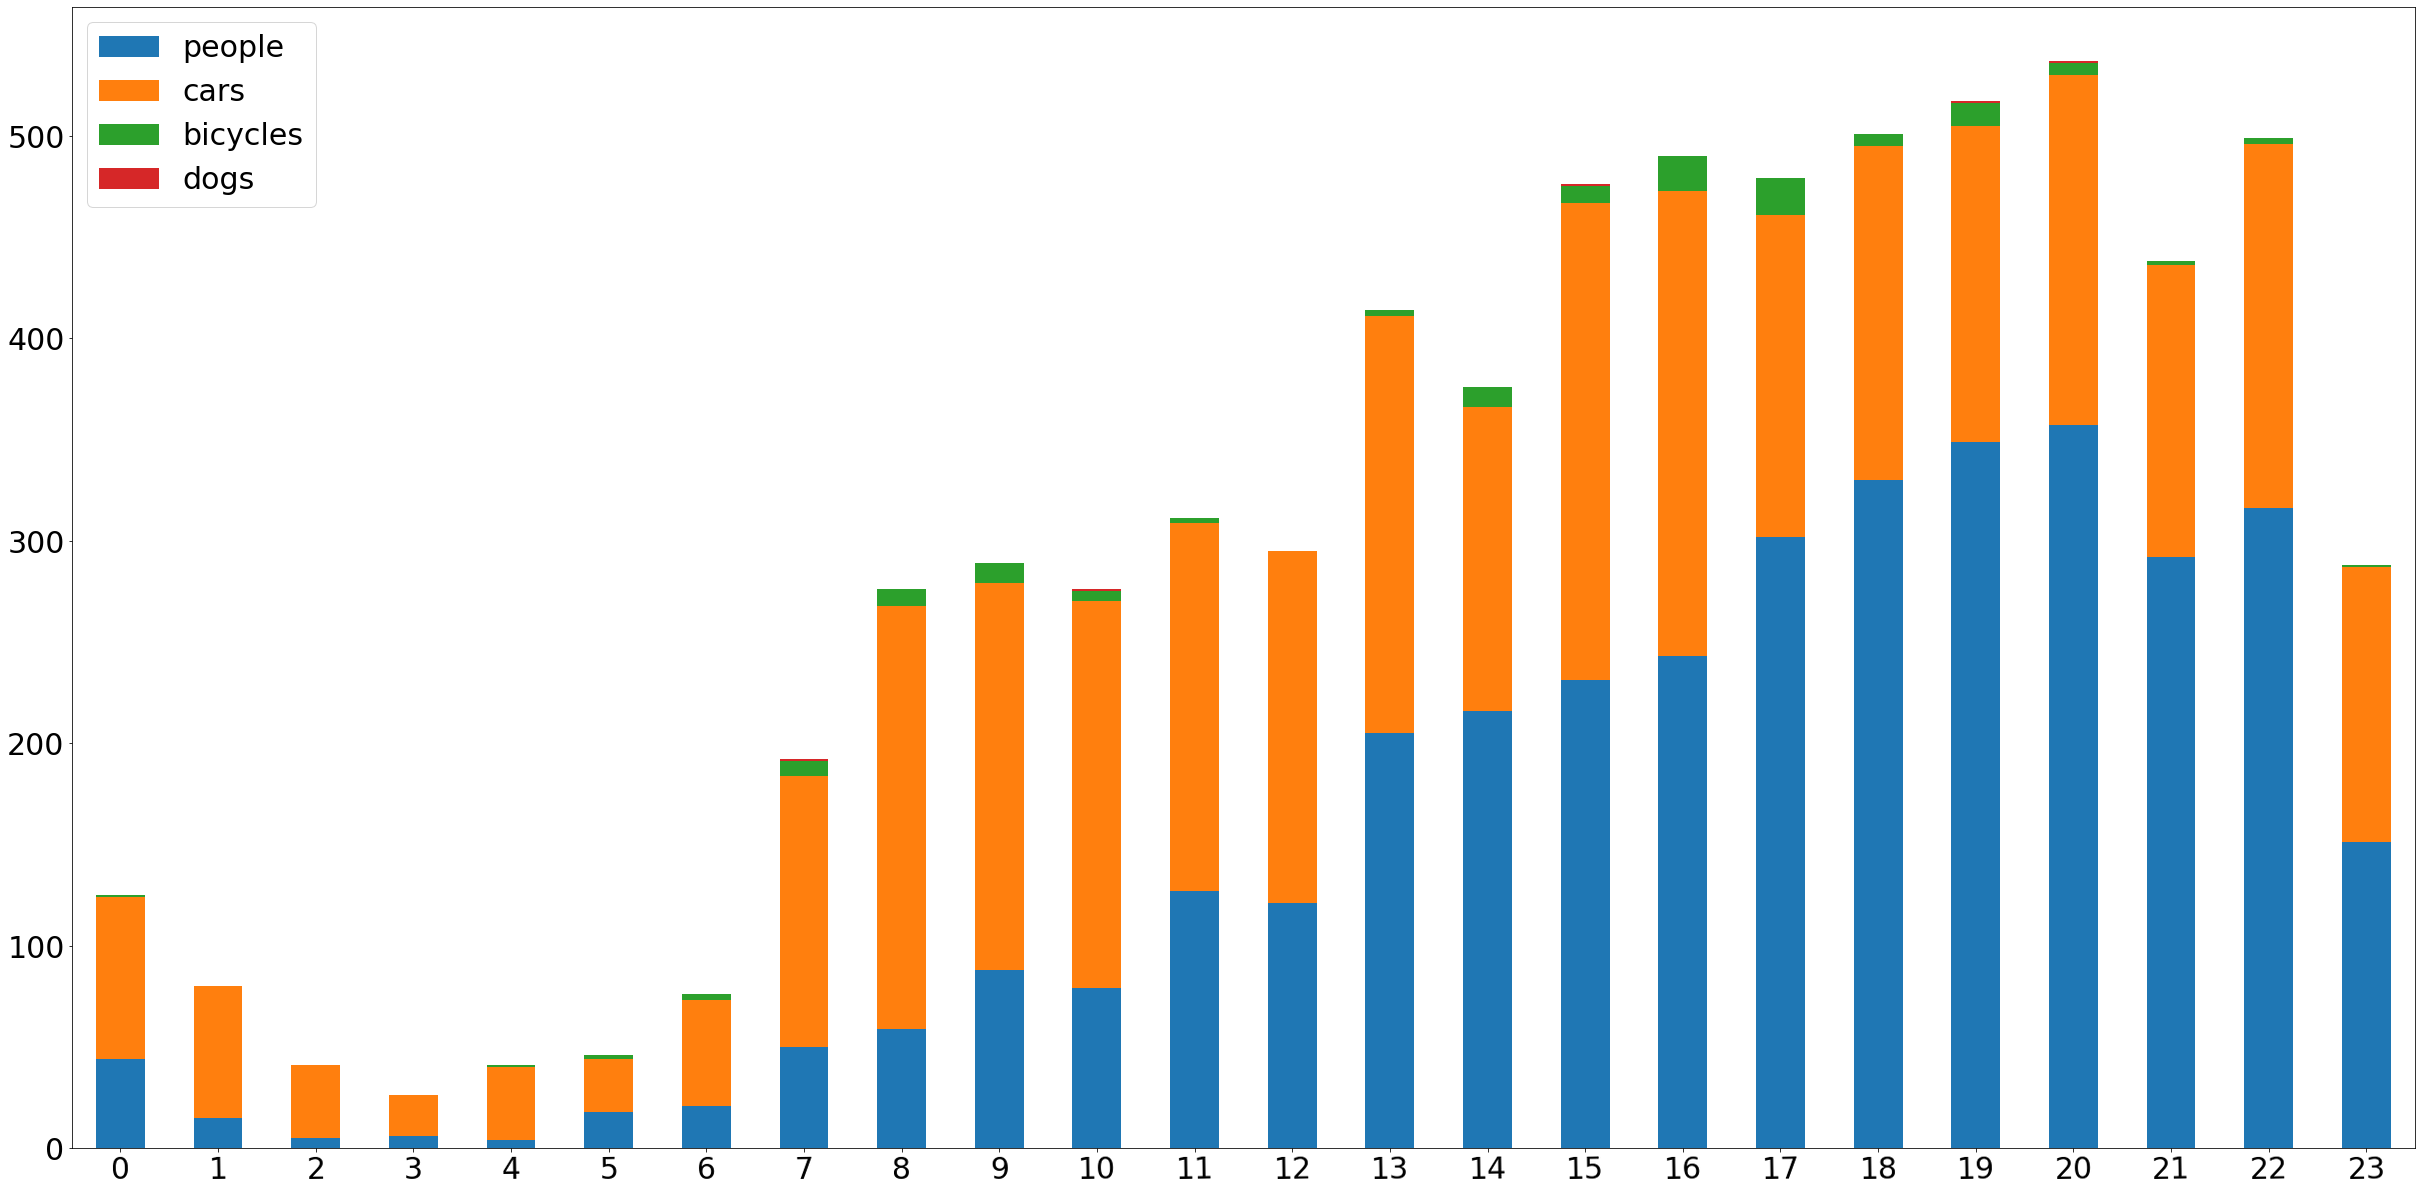

In [8]:
import pandas as pd

df = pd.DataFrame.from_dict(hour_bins, orient='index')
print(df)
df.plot(kind="bar", stacked=True, fontsize=30, rot=1)
plt.legend(prop={'size': 30})
plt.show()